Epoch 1/200


/Users/sugang/Desktop/projects/2024coin/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0568 - val_loss: 0.0034
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0101 - val_loss: 6.3582e-04
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - val_loss: 7.5333e-04
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079 - val_loss: 7.3519e-04
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - val_loss: 9.1283e-04
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test RMSE: 3358946.396392848
Total RMSE: 3247332.908122748
Total R² Score: 0.9857749813404209


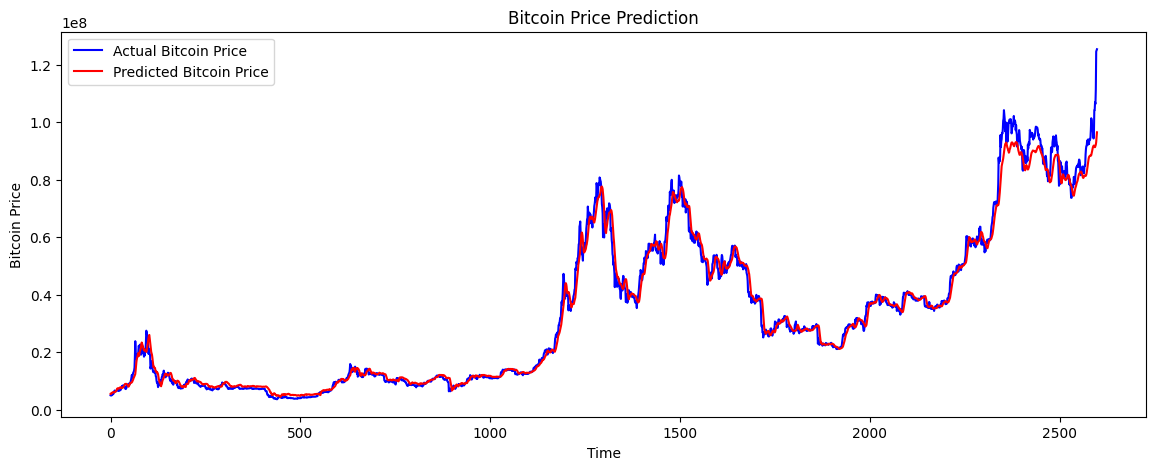

CSV saved as 'full_data_with_predictions.csv'


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import os
# Change the working directory to strategy_lab
os.chdir("/Users/sugang/Desktop/projects/2024coin/strategy_lab")

import matplotlib.pyplot as plt
from handle_candle import resample_df
from datetime import datetime
from sklearn.model_selection import train_test_split



# Load the full original data
df_full = pd.read_csv('temp.csv')

# Preprocess the full data for time resampling
execution_time = datetime.strptime("00:00", "%H:%M")
df_full = resample_df(df_full, execution_time=execution_time)

# Calculate the Daily Return and remove unwanted columns
df_full['Daily Return'] = df_full['close'].pct_change()
df_full.dropna(inplace=True)  # Remove NaN values caused by percentage change

# Save the full DataFrame before dropping columns
df_preprocessed = df_full.copy()

# Use only the required features for model training
df_full.drop(columns=["time_utc"], inplace=True)
features = df_full[['open', 'high', 'low', 'close', 'volume_krw', 'volume_market', 'Daily Return']].values

# Normalize features and close prices
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(df_full[['close']].values)

# Prepare the data for LSTM
sequence_length = 7
x, y = [], []

for i in range(sequence_length, len(scaled_features)):
    x.append(scaled_features[i-sequence_length:i])
    y.append(scaled_close[i, 0])  # Predicting the scaled 'close' price

x, y = np.array(x), np.array(y)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Build and compile the LSTM model with the specified hyperparameters
model = Sequential()
model.add(LSTM(units=64, activation='tanh', return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=4, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with the specified parameters
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(x_train, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the test set and the entire dataset
predictions_test = model.predict(x_test)
predictions_total = model.predict(x)

# Inverse transform predictions and original values
predictions_test = close_scaler.inverse_transform(predictions_test)
predictions_total = close_scaler.inverse_transform(predictions_total)
y_test_original = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_original = close_scaler.inverse_transform(y.reshape(-1, 1))

# Calculate RMSE for the test set and the entire dataset
rmse_test = np.sqrt(mean_squared_error(y_test_original, predictions_test))
rmse_total = np.sqrt(mean_squared_error(y_original, predictions_total))
r2_total = r2_score(y_original, predictions_total)

print(f"Test RMSE: {rmse_test}")
print(f"Total RMSE: {rmse_total}")
print(f"Total R² Score: {r2_total}")

# Plot the results for the entire dataset
plt.figure(figsize=(14, 5))
plt.plot(y_original, color='blue', label='Actual Bitcoin Price')
plt.plot(predictions_total, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

# Append predictions to the full DataFrame
df_results = df_preprocessed.iloc[sequence_length:].copy()  # Skip the initial sequence length
df_results['predict_close'] = predictions_total

# Save the updated DataFrame as a CSV file
df_results.to_csv('2/full_data_with_predictions.csv', index=False)

# Print the path to the saved CSV file
print("CSV saved as 'full_data_with_predictions.csv'")
